# Homework 4

In this notebook, you will explore kernel ridge regression and kernel SVM. We first present kernel ridge regression on a housing dataset to showcase the ideas in Question 4 on the theoretical portion of the homework. Next, we start our exploration into kernel SVM with a two-dimensional example on the spiral data and then build a simple but powerful sentiment classifier on tweets to airlines, a topic we may have more sympathy for as inclement weather hits us here in Chicago...

## Preparation

In [9]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn import svm
import matplotlib.pyplot as plt
import utils

## Kernel Ridge Regression

In the Question 3 of the theoretical homework, we studied kernel ridge regression. In this part, we will address the practical considerations for solving the kernel ridge regression problem.

We consider the [California housing dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset), which consists of 8 numeric features, including house age, number of bedrooms, and location, and has target median house value. It contains over 20 thousand samples. We will use 3000 for now, but feel free to use more to see what happens! First, let us load it from `sklearn`'s set of datasets.

In [2]:
cal  = sklearn.datasets.fetch_california_housing()

In [3]:
from utils import TrainAndTestData

seed = 0
np.random.seed(seed)

m = 3000
perm = np.random.permutation(len(cal.target))
train_i = perm[:m]
test_i = perm[m:]
train_X = cal.data[train_i,:]
train_y = cal.target[train_i]
test_X = cal.data[test_i,:]
test_y = cal.target[test_i]

housing_data = TrainAndTestData(train_X, train_y, test_X, test_y)

Let use a Gaussian (RBF) kernel. Recall that the definition of this kernel is:

$$
    K_{RBF}(x_i, x_j) = \exp \left( -\beta \left(  \langle x_i, x_i \rangle + \langle x_j, x_j \rangle - 2\langle x_i, x_j \rangle  \right)    \right)
$$

In [4]:
def RBF_kernel(beta = 1):
    def RBF_kernel_beta(x1,x2):
        return np.exp(- beta*(np.sum(x1*x1, 1)[:,np.newaxis] + np.sum(x2*x2, 1)-2*x1@x2.T ))
    return RBF_kernel_beta

*A quick note on closure: the above kernel construction function employs a Python concept known as `closure` which provides us the following functionality. Every kernel function should have the same signature: given two data points as input, output a real number. However, the function may be dependent on some parameter that we cannot hard code. Thus, the outer function constructs a kernel function with the desired signature while fixing a value for the parameter. This becomes very useful when we may need to pass around a kernel function but always for the same parameter value*

To use this function, we first pick some value of `beta` and instantiate: `RBF_kernel(beta=myvalue)`. This is itself a function and can now take in matrices `x1, x1`. That is:

In [5]:
RBF_kernel(beta = 1)(housing_data.X_train[:10], housing_data.X_train[:10])

array([[1.00000000e+000, 0.00000000e+000, 1.24418120e-052,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000],
       [0.00000000e+000, 1.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000],
       [1.24418120e-052, 0.00000000e+000, 9.99999999e-001,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        5.13597624e-152],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 1.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.0

### [Task 1] Looking for a great $\beta$ value
Look at the values of the kernel for that setting of $\beta$. What do you notice about the values? Generally, what values is the Gaussian kernel distributed between (consider limiting cases: large distance / exponent, small distance exponent). What part of that range does the above lie in? How can you improve this? Find a good setting for $\beta$ by considering these questions.

In [13]:
df = pd.DataFrame(housing_data.X_train)
df.head()

,0,1,2,3,4,5,6,7
0,4.1518,22.0,5.663073,1.075472,1551.0,4.180593,32.58,-117.05
1,5.7796,32.0,6.107226,0.927739,1296.0,3.020979,33.92,-117.97
2,4.3487,29.0,5.930712,1.026217,1554.0,2.910112,38.65,-121.84
3,2.4511,37.0,4.992958,1.316901,390.0,2.746479,33.20,-115.60
4,5.0049,25.0,4.319261,1.039578,649.0,1.712401,37.79,-122.43


In [36]:
#### TASK 1 CODE
RBF_kernel(beta = 1e-6)(housing_data.X_train[:10], housing_data.X_train[:10])
#### TASK 1 CODE

array([[1.00000000e+00, 9.36943914e-01, 9.99880491e-01, 2.59719275e-01,
        4.43225010e-01, 1.69000669e-01, 8.28245222e-01, 5.63670719e-01,
        4.23646649e-02, 2.49530705e-01],
       [9.36943914e-01, 1.00000000e+00, 9.35557706e-01, 4.40044385e-01,
        6.57902595e-01, 3.12693447e-01, 9.68188366e-01, 7.77221541e-01,
        1.60263814e-02, 4.26528072e-01],
       [9.99880491e-01, 9.35557706e-01, 1.00000000e+00, 2.57938723e-01,
        4.40851784e-01, 1.67724622e-01, 8.26013840e-01, 5.61188437e-01,
        4.28127494e-02, 2.47827682e-01],
       [2.59719275e-01, 4.40044385e-01, 2.57938723e-01, 1.00000000e+00,
        9.34913900e-01, 9.70565732e-01, 5.89165995e-01, 8.49388991e-01,
        1.77166003e-04, 9.99651704e-01],
       [4.43225010e-01, 6.57902595e-01, 4.40851784e-01, 9.34913900e-01,
        1.00000000e+00, 8.29861783e-01, 8.03229221e-01, 9.79021546e-01,
        7.59706993e-04, 9.26285461e-01],
       [1.69000669e-01, 3.12693447e-01, 1.67724622e-01, 9.70565732e-01,
   

Armed with a good kernel to represent our features well, we move on to the learning algorithm.

### [Task 2] Implementing Kernel Ridge Regression
Now, let us implement the kernel ridge regression solution. In 3(b), you formulated the solution to the kernel ridge regression as computing the least squares solution to some expression. Finish the function below using proper numeric python syntax. Also compute the prediction given the kernel, the validation points, the predictor, and the training points (`predict_kernel_ridge`).

In [24]:
def train_kernel_ridge(kernel, lmbd, x, y):
    from numpy.linalg import lstsq
    K = kernel(x,x)
    m = len(x)
    #### TASK 2 CODE
    least_squares_soln = np.linalg.inv(K + m * lmbd / 2 * np.identity(m)) @ y
    #### TASK 2 CODE
    return least_squares_soln

In [25]:
def predict_kernel_ridge(kernel, x, alpha, train_x):
    #### TASK 2 CODE
    return alpha.T @ kernel(train_x, x)
    #### TASK 2 CODE

Given this, load and process the data into the Gram matrix, compute the KRR solution for this data for some fixed regularization parameter $\lambda$, and predict the answers on a validation set.

**Check yourself**: How long does the `train_kernel_ridge` function take to run? Are you inverting a matrix?

Great. You now are able to compute the KRR solution for data. Let's compute some baselines to know what we're trying to beat. Compute the mean squared error for the following two (extremely simple) predictors:
* **null predictor**: output 0 for every data point
* **mean predictor**: output the mean of the training `y` for every data point

In [26]:
def mean_squared_error(pred, y):
    return np.mean((pred-y)**2)

In [27]:
#### TASK 2 CODE
## BASELINES
print(f"constant null predictor: {mean_squared_error(0, housing_data.y_test)}")
print(f"mean predictor: {mean_squared_error(np.mean(housing_data.y_train), housing_data.y_test)}")
#### TASK 2 CODE

constant null predictor: 5.616474735605584
mean predictor: 1.3313742301305194


<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 1]</h4>

Use cross-validation or validation to choose $\lambda$. Make sure you beat the baselines. What values of $\beta, \lambda$ give good performance? <br>

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">

Answer: $\beta = 10^{-6}, \lambda = 10^{-7}$ , among the ones chosen in the candidate pool below.

</span>


<h4 style="font-weight: bold">---------------------</h4>
</span>

In [47]:
#### CODE
# Use validation for both beta and lambda
lambdas = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
betas = [1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]
Xt, yt, Xv, yv = utils.create_split(housing_data.X_train, housing_data.y_train, 0.7)

best_b, best_l = None, None
best_err = np.inf
for b in betas:
    val_errs_l = []
    for l in lambdas:
        ker = RBF_kernel(b)
        yp = predict_kernel_ridge(ker, Xv, train_kernel_ridge(ker, l, Xt, yt), Xt)
        if mean_squared_error(yp, yv) < best_err:
            best_b = b
            best_l = l
            best_err = mean_squared_error(yp, yv)
            
            
print(f"Best validation error = {best_err} was achieved by beta: {best_b} and lambda: {best_l}")

# Retrain on entire training set
print(f"Test error: {mean_squared_error(predict_kernel_ridge(RBF_kernel(best_b), housing_data.X_test, train_kernel_ridge(RBF_kernel(best_b), best_l, housing_data.X_train, housing_data.y_train), housing_data.X_train), housing_data.y_test)}")
    
#### CODE

Best validation error = 0.48524055206433203 was achieved by beta: 1e-06 and lambda: 1e-07
Test error: 0.5777850640504556


## 2D kernel SVM

In this part, we revisit the spiral dataset. We will walk through solving this problem using the radial basis function kernels. Your job will be to understand how well the predictor works. After this, we encourage you to explore trying different kernels and parameter settings to see how they perform. We will use the [implementation of SVM in `scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

In [40]:
np.random.seed(0)

LABELS = [-1, 1]
SP_THETA_SIGMA = 0.3
SP_R_SIGMA = 0.05
NOISE_LEVEL = 0.2

m = 1000
Xsp, ysp = utils.generate_spiral_data(m, noise_level=NOISE_LEVEL, theta_sigma=SP_THETA_SIGMA, r_sigma=SP_R_SIGMA)

train_test_ratio = 0.8
Xsp_train, ysp_train, Xsp_test, ysp_test = utils.create_split(Xsp, ysp, train_test_ratio)

spirals = TrainAndTestData(Xsp_train, ysp_train, Xsp_test, ysp_test)

See how RBF kernel (sigma) compares to the $k$-Nearest Neighbor predictor and decision tree predictors from HW3.

Train error: 9.00%
Test error: 6.00%


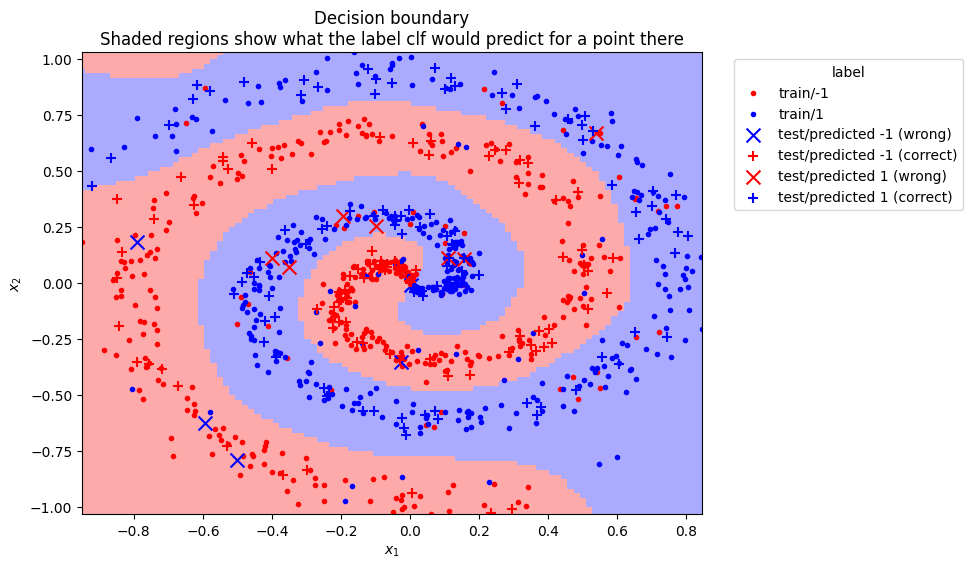

In [41]:
# for now, kernel = one of ['linear', 'poly', 'rbf']
# the relevant parameters are degree, gamma -- see documentation for details of how to use them
svm_clf = svm.SVC(kernel='rbf', gamma=10, C=5)
svm_clf = svm_clf.fit(Xsp_train, ysp_train)
utils.plot_decision_boundary(svm_clf, Xsp_train, ysp_train, Xsp_test, ysp_test)

spirals.print_errors(svm_clf)

### [Task 3] Applying SVM classifiers to the 2D spiral data
For the classifier you trained, find and write down the value of the SVM object, training loss, and training error, margin violations, and the number of support vectors.

Best validation error = 0.1125 was achieved by gamma: 10.0 and C: 10.0
# support vectors: [128 121]
Train error: 8.88%
Test error: 6.50%


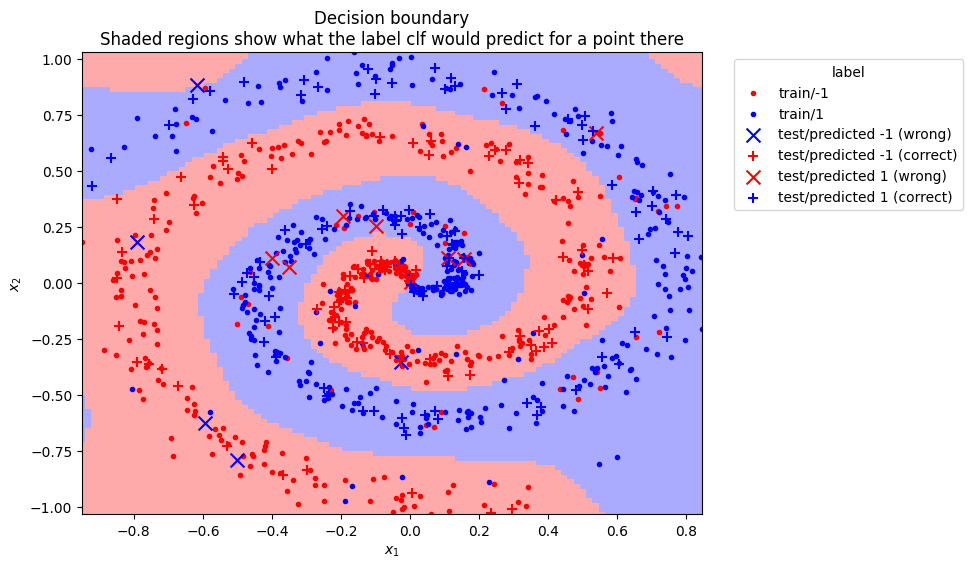

In [59]:
#### TASK 3 CODE
gammas = np.power(10, np.arange(-5, 6).astype(float))
cs = np.power(10, np.arange(-5, 6).astype(float))
Xt, yt, Xv, yv = utils.create_split(spirals.X_train, spirals.y_train, 0.8)

best_g, best_c = None, None
best_err = np.inf
for g in gammas:
    for c in cs:
        clf = svm.SVC(kernel="rbf", gamma = g, C = c)
        clf.fit(Xt, yt)
        err = utils.empirical_err(clf, Xv, yv)
        if err < best_err:
            best_g = g
            best_c = c
            best_err = err


print(f"Best validation error = {best_err} was achieved by gamma: {best_g} and C: {best_c}")

final_svm_clf = svm.SVC(kernel="rbf", gamma = best_g, C = best_c)
final_svm_clf.fit(spirals.X_train, spirals.y_train)
print(f"# support vectors: {final_svm_clf.n_support_}")
spirals.print_errors(final_svm_clf)
utils.plot_decision_boundary(final_svm_clf, Xsp_train, ysp_train, Xsp_test, ysp_test)
#### TASK 3 CODE

In [60]:
final_svm_clf

SVC(C=10.0, gamma=10.0)

<span style="color: red">
<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">

Answer: It has $C = 100.0, gamma = 10$, training error = 8.88%, test error = 6.50%, #support vectors in each category = [128, 121]
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

Explore different kernels, parameter values, and regularization parameters to see how these factors affect the learned classifier. Spend some time exploring here to understand the influence of these factors, since in the next part, you will be using the same techniques, but this time on data that lies in much higher than 2D, so plotting to analyze what you get is not really an option.

## Sentiment Analysis Using Kernel SVM

Next, we will develop a sentiment classifier using kernel SVM. We will work with a real-world dataset of [tweets to airlines](https://www.kaggle.com/crowdflower/twitter-airline-sentiment/version/2). Datasets that have been scraped from the internet (such as this one) are prone to many issues, whether we use them directly or with some filtering. See if you can think of a few potential issues, and feel free to discuss with TAs at office hours. Despite these issues, the dataset provides value in giving us short statements with strong sentiment that we will build a classifier over.

**Data pre-processing** The raw data, which you can access and study at the above link, contains 15 attributes, including `tweet_id` , `airline_sentiment`, `negative_reason`, `airline`, `text.` Of these, we are most interested in `airline_sentiment` and `text`. To that end, we have extracted these for you in the files `cleaned_tweets_train.tsv` and `cleaned_tweets_test.tsv`. A `tsv` file is a file where the different attributes are separated by tabs. The dataset identifies three different sentiments: `positive`, `neutral`, and `negative`. After extracting just the tweets and the sentiments, we shuffled all the tweets and saved the first 3/4 of them to the training file and the remaining 1/4 of them to the test file.

**Data loading** The `load_data` function we provide in `utils.py` allows filtering neutral (i.e., removing them from the data) by setting `filter_neutrals` flag to `True` or including them but counting them as "not positive" examples by setting `filter_neutrals` flag to `False`.

### Kernel Functions

Recall that a kernel can be defined as $K_{ij} = \langle \phi(x_i), \phi(x_j) \rangle\, \in \mathbb{R}\,.$ However, the $x_i$ do not have to be real-valued, or numeric at all. Indeed, in this case, they are strings of length $k$ (tweets, in particular) in $\mathcal{D}^k$, where $\mathcal{D}$ is the dictionary of words. Then, we can decompose the kernel as:


$$
K_{ij} = \langle \phi(x_i), \phi(x_j) \rangle = \langle \tilde{\phi}(v(x_i)), \tilde{\phi}(v(x_j))\rangle\
$$


where $\phi = \tilde{\phi} \circ v\,,$ $\tilde{\phi} \, : \mathbb{R}^{d_1} \mapsto \mathbb{R}^{d_2}$ and $v \, : \mathcal{D}^k \mapsto \mathbb{R}^{d_1}\,.$

This decomposition allows us to separate the transformation into two parts. Now, we can choose both independently. Here are some suggestions for each:

* For $v(x_i)\,:$
    * **Bag-of-words**: for each word $w$ in the corpus, the corresponding component of the bag-of-words representation of $x_i$ is defined as the number of occurences of $w$ in $x_i$.
    * **Bi-gram**: for each pair of words that occur contiguously in the corpus, the corresponding component of the bi-gram representation of $x_i$ is the number of times that the bi-gram (two-word pattern) appears in $x_i$.
    * **Subsequence counts**: for each subsequence (of fixed size) in the corpus, the corresponding component of this representation of $x_i$ is the nubmer of times that the subsequence has appeared in the document $x_i.$ (A subsequence allows for skipping characters, whereas a substring is all continguous characters.)
    * ...others?



* For $\tilde{\phi}\,:$
    * Linear
    * Polynomial
    * Radial basis function
    * Weighted cosine similarity (word kernel in the pdf)
    * ...others?

Here, we implement several kernels with which you may experiment. **You should also try at least one combination that we have not implemented for you.**

**Check your understanding**:
* what is the dimension of a bag-of-words representation of a sentence? what about bigram?

In [98]:
def BoW_inner(s1,s2):
    "returns inner product between bag-of-word feature vectors of the two input strings"
    from collections import Counter
    d1 = Counter(s1.split())
    return sum(d1[w] for w in s2.split())

<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 2]</h4>

No coding in this one: Consider the BoW kernel constructed in `BoW_inner`. Suppose there are $D$ words in the corpus, and each sentence (document) has at most $k$ words.
* What is the time and space complexity of naively constructing the bag-of-words vector for each sentence and computing their inner product?
* What is the time and space complexity of the implementation in the code?
* What accounts for the difference? <br>

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">

Answer:
- Naive constructing BoW vector:
  - Time: $O(mk)$
  - Space: $O(mD)$ to store all $m$ $D$-dim vectors
- Naive computing inner product after construction:
  - Time: $O(m^2D)$
  - Space: $O(m^2)$ to store the inner products
- Alternative implementation altogether:
  - Time: $O(m^2k^2)$
  - Space: $O(m^2)$ to store the inner products
- The difference lies in that to compute the inner product of 2 sentences (document), only the count of their shared words matters, so instead of counting for all $D$ words in the dictionary, only the $k$ words each of each sentence matter.
</span>

<h4 style="font-weight: bold">---------------------</h4>
</span>

### [Task 4] Implementing your own feature mapping function for text data

Think about your own understanding of sentences. What features do you use to understand them? **Hand design a feature mapping from sentence to numeric values that might help a kernel learn to classify sentiment.** To do this, you may wish to load the training data and inspect what positive and negative samples look like.

In [62]:
X_train, y_train = utils.load_data(os.path.join(os.getcwd(),"data/cleaned_tweets_train.tsv"))

In [91]:
print("---- positive samples ----")
for i in range(1000):
    if y_train[i] == 1:
        print(X_train[i])
print("--------------------------")
print("---- negative samples ----")
for i in range(200):
    if y_train[i] == -1:
        print(X_train[i])
print("--------------------------")

---- positive samples ----
@united flight 1491...plane from SFO to DEN is basically on time.
@united thank you for getting our daughter home when @americanair Cancelled Flightled all their flights to Nashville
"@united sweet
@united thanks for not getting my BusinessFirst priority tagged bag onto my connecting flight at EWR despite a 2+ hour layover. Nice job
@united man I can't wait to book my ticket now! Thanks JP you're a life sabe
@JetBlue thanks so much for your condolences and quick response. It is very much appreciated
@JetBlue Thanks for the $100 credit because of the 4hr delay. I can tell customer service means a lot to YOU #Thankful
@SouthwestAir is the best airline out there no one is better than them #OneLove #Southwest #bestairline
@united My favorite way to travel! Thank you! http://t.co/vGN2X1ckg0
@USAirways Kudos to Robin at @PHXSkyHarbor Lost/Found for reuniting me w/ my iPad. She was delightful to work with!
@SouthwestAir thanks for getting me back to Nashville. Big t

In [92]:
from collections import Counter
SENTIMENTAL_WORDS = ["thanks", "favorite", "kudos", "appreciate", "helping", "thank", "great", "love", "best", "good", "awesome", "impressed", "win", "amazing", "worthless", "hate", "cancelled", "where", "time", "issue", "miss", "frustrated", "email", "ridiculous", "bad", "horrible", "wait", "leave", "cancel", "cancelled"]
def bag_of_sentimental_words(x1):
    # count the number of words that are strongly related to sentiments
    #### TASK 4 CODE
    counter = Counter(x1.strip().lower().split())
    return np.array([counter[word] for word in SENTIMENTAL_WORDS])
    #### TASK 4 CODE

In [93]:
def my_inner_product(x1, x2):
    '''
    this function computes the inner product phi(x1)*phi(x2) for phi,
        the feature transform defined in the previous cell, i.e., my_feature_map
    implementing this as np.dot(my_feature_map(x1), my_feature_map(x2)) is not
        super-useful, as the runtime will be at least linear in the dimension of
        the feature map. Instead, implement this without ever using my_feature_map.
    '''
    #### TASK 4 CODE
    d1 = Counter(x1.strip().lower().split())
    return sum(d1[w] for w in x2.strip().lower().split() if w in SENTIMENTAL_WORDS)
    #### TASK 4 CODE

Next, we compute the Gram matrix from any kernel we have implemented (e.g., the one you just implemented or the bag-of-words example given in function `BoW_inner`. This is useful in computing $\tilde{\phi}$ for $\tilde{\phi}$ that can be vectorized.

In [94]:
def gram_matrix(K):
    def gram_matrix_K(xs_1, xs_2):
        return np.array([[K(x1, x2) for x2 in xs_2] for x1 in xs_1])
    return gram_matrix_K

In [95]:
def rbf_kernel_gram(inner, beta=1):
    """Gaussian RBF kernel.

    Returns a function gram(xs_1,xs_2) that calculate the (cross) gram matrix G[i,j]=K(xs_1[i,xs_2[j]])
    where K is the Gaussian RBF on the features phi, specified through the inner product in phi space."""
    def rbf_kernel_sigma_inner(xs_1,xs_2):
        return np.exp(-beta*(np.array([inner(x1, x1) for x1 in xs_1])[:, np.newaxis]
                             + np.array([inner(x2, x2) for x2 in xs_2])
                             - 2*gram_matrix(inner)(xs_1, xs_2)))
    return rbf_kernel_sigma_inner

In [96]:
def poly_kernel_gram(inner, deg, alpha=1.0):
    def poly_kernel_deg_alpha(xs_1, xs_2):
        return (alpha + gram_matrix(inner)(xs_1, xs_2))**deg
    return poly_kernel_deg_alpha

*A quick note on closure: the above kernel construction functions employ a Python concept known as `closure` which provides us the following functionality. Every kernel function should have the same signature: given two data points as input, output a real number. However, the function may be dependent on some parameter that we cannot hard code. Thus, the outer function constructs a kernel function with the desired signature while fixing a value for the parameter. This becomes very useful when we later need to compute kernel values for all pairs of input for a fixed parameter value.*

Let us see how to generate the RBF kernel matrix using `BoW_inner` and `my_inner_product` as $\langle v(x_i), v(x_j)\rangle$ for some value of the parameter $\beta\,.$ Note that `rbf_kernel_gram(inner, beta)` returns a function, and we pass it the datasets as arguments.

In [99]:
rbf_kernel_gram(BoW_inner,0.2)(X_train[:10],X_train[5:12])

array([[1.11377515e-03, 1.49955768e-02, 8.22974705e-03, 3.35462628e-04,
        1.49955768e-02, 1.01039402e-04, 5.00451433e-04],
       [3.35462628e-04, 4.51658094e-03, 1.66155727e-03, 1.50733075e-04,
        3.02755475e-03, 1.36741961e-05, 1.50733075e-04],
       [3.69786372e-03, 4.97870684e-02, 1.83156389e-02, 1.66155727e-03,
        3.33732700e-02, 1.01039402e-04, 1.66155727e-03],
       [2.47875218e-03, 1.49955768e-02, 1.22773399e-02, 5.00451433e-04,
        1.49955768e-02, 1.01039402e-04, 1.11377515e-03],
       [7.46585808e-04, 1.00518357e-02, 5.51656442e-03, 5.00451433e-04,
        6.73794700e-03, 2.03995034e-05, 3.35462628e-04],
       [1.00000000e+00, 4.51658094e-03, 1.66155727e-03, 1.01039402e-04,
        4.51658094e-03, 3.04324830e-05, 1.50733075e-04],
       [4.51658094e-03, 1.00000000e+00, 1.00518357e-02, 6.11252761e-04,
        2.73237224e-02, 1.23409804e-04, 9.11881966e-04],
       [1.66155727e-03, 1.00518357e-02, 1.00000000e+00, 5.00451433e-04,
        1.49955768e-02, 6

In [103]:
rbf_kernel_gram(my_inner_product,0.2)(X_train[:10],X_train[5:12])

array([[0.81873075, 0.81873075, 0.81873075, 0.81873075, 1.        ,
        1.        , 1.        ],
       [0.44932896, 0.44932896, 0.44932896, 0.44932896, 0.54881164,
        0.54881164, 0.54881164],
       [0.81873075, 0.81873075, 0.81873075, 0.81873075, 1.        ,
        1.        , 1.        ],
       [0.81873075, 0.81873075, 0.81873075, 0.81873075, 1.        ,
        1.        , 1.        ],
       [0.81873075, 0.81873075, 0.81873075, 0.81873075, 1.        ,
        1.        , 1.        ],
       [1.        , 0.67032005, 0.67032005, 0.67032005, 0.81873075,
        0.81873075, 0.81873075],
       [0.67032005, 1.        , 0.67032005, 0.67032005, 0.81873075,
        0.81873075, 0.81873075],
       [0.67032005, 0.67032005, 1.        , 0.67032005, 0.81873075,
        0.81873075, 0.81873075],
       [0.67032005, 0.67032005, 0.67032005, 1.        , 0.81873075,
        0.81873075, 0.81873075],
       [0.81873075, 0.81873075, 0.81873075, 0.81873075, 1.        ,
        1.        , 1. 

### Train SVM

Now that we know how to extract and kernelize our data, let us train SVM on it. Note that $C = 1/\lambda\,,$ where $\lambda$ is the regularization parameter we discussed in class. Use a validation set to evaluate the performance of the classifiers you train. As an example, here is how you might use `sklearn`'s SVM implementation:

In [101]:
svm_clf = svm.SVC(kernel=poly_kernel_gram(BoW_inner, 2))
svm_clf= svm_clf.fit(X_train[:100], y_train[:100])
preds = svm_clf.predict(X_train[200:220])

### [Task 5] Optimizing your SVM classifier
We give you a set of questions below to explore and some direction regarding how to explore them. As your "answer" for this section, submit a write-up in the notebook with 2-3 plots about the answers to these questions. Also submit your code as applicable.

* For differing kernels, train SVM with different $\lambda$ spanning a good range. Use cross validation to determine a good value of $\lambda$. What are the resulted (1) 0-1, Hinge training loss? (2) Margin loss? (3) Test error? (4) Support Vectors?

* Identify examples where the classifier fails for different kernels. Speculate on what the various kernels might be more suited to.

* You implemented your own kernel: how did that do? did the performance match what you were expecting? if not, what factors might have influenced that?

* Consider the various attributes of a machine learning algorithm we may be interested in practically: generalization, runtime, memory usage, ease of implementation, understandability. How does kernel SVM for the kernels you tried perform on each of these attributes?


After evaluating the different classifiers you developed based on various design choices, evaluate the performance of the one you've chosen to "ship". In particular, BEFORE LOADING THE TEST DATA, write your final prediction function, which accepts as input a list of strings to predict on:

# Work:

The RBF kernel with sentimental words only performed slightly better than RBF with all words, which was interesting as I thought that the bag of all words would capture all the "data" that is expressed by the sentimental words; however perhaps some word signals were just confusing to the all-words model, resulting in a higher validation error.

The runtime is definitely an issue for these (custom) kernel SVMs, they took so long (on my laptop) to train. However, they're relatively easy to implement and understand.

### RBF with Bag of All Words
**I decided to simply use validation, since training for each SVM takes quite a long while**

In [201]:
Xt, yt, Xv, yv = X_train[:2000], y_train[:2000], X_train[2000:], y_train[2000:]

In [202]:
from sklearn.metrics import hinge_loss, zero_one_loss

cs = np.power(10, np.arange(-2, 4).astype(float))
gammas = np.power(10, np.arange(-1, 2).astype(float))

val_err_c = np.ones(len(cs)) * np.inf
best_g_of_c = np.zeros(len(cs))
best_clf = None
all_best = np.inf
for c_idx, c in enumerate(cs):
    best_err = np.inf
    for g in gammas:
        print(f"c:{c}, g: {g}")
        svm_clf = svm.SVC(kernel=rbf_kernel_gram(BoW_inner, g), C = c)
        svm_clf.fit(Xt, yt)
        err = utils.empirical_err(svm_clf, Xv, yv)
        if err < val_err_c[c_idx]:
            val_err_c[c_idx] = err
            best_g_of_c[c_idx] = g
        if err < all_best:
            all_best = err
            best_clf = svm_clf

rbf_bow_best_clf = best_clf

c:0.01, g: 0.1
c:0.01, g: 1.0
c:0.01, g: 10.0
c:0.1, g: 0.1
c:0.1, g: 1.0
c:0.1, g: 10.0
c:1.0, g: 0.1
c:1.0, g: 1.0
c:1.0, g: 10.0
c:10.0, g: 0.1
c:10.0, g: 1.0
c:10.0, g: 10.0
c:100.0, g: 0.1
c:100.0, g: 1.0
c:100.0, g: 10.0
c:1000.0, g: 0.1
c:1000.0, g: 1.0
c:1000.0, g: 10.0


Text(0.5, 1.0, 'Validation Error vs log(C) for RBF, BoW inner, SVM')

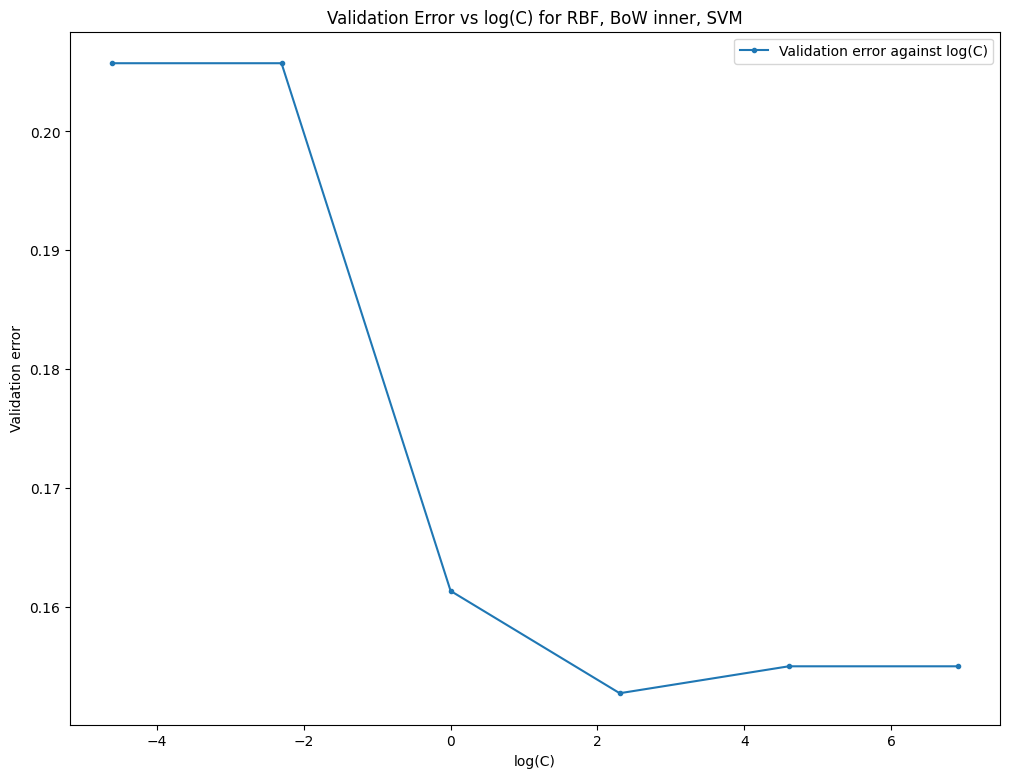

In [203]:
plt.figure(figsize=(12,9))
plt.plot(np.log(cs), val_err_c, label=f'Validation error against log(C)', marker='.')
plt.legend()
plt.xlabel('log(C)')
plt.ylabel('Validation error')
plt.title(f'Validation Error vs log(C) for RBF, BoW inner, SVM')

In [204]:
best_c = cs[np.argmin(val_err_c)]
best_g = gammas[np.argmin(val_err_c)]
print(f"BEST CLF: c: {best_c}, g: {best_g}")
print(f"# support vectors: {rbf_bow_best_clf.n_support_}")
print(f"Zero-one loss on training set: {zero_one_loss(yt, rbf_bow_best_clf.predict(Xt))}")
print(f"Zero-one loss on validation set: {zero_one_loss(yv, rbf_bow_best_clf.predict(Xv))}")
print(f"Hinge loss on training set: {hinge_loss(yt, rbf_bow_best_clf.decision_function(Xt))}")
print(f"Hinge loss on validation set: {hinge_loss(yv, rbf_bow_best_clf.decision_function(Xv))}")


IndexError: index 3 is out of bounds for axis 0 with size 3

### RBF with Bag of sentimental words

In [ ]:
from sklearn.metrics import hinge_loss, zero_one_loss

cs = np.power(10, np.arange(-2, 4).astype(float))
gammas = np.power(10, np.arange(-1, 2).astype(float))

val_err_c = np.ones(len(cs)) * np.inf
best_g_of_c = np.zeros(len(cs))
best_clf = None
all_best = np.inf
for c_idx, c in enumerate(cs):
    best_err = np.inf
    for g in gammas:
        print(f"c:{c}, g: {g}")
        svm_clf = svm.SVC(kernel=rbf_kernel_gram(my_inner_product, g), C = c)
        svm_clf.fit(Xt, yt)
        err = utils.empirical_err(svm_clf, Xv, yv)
        if err < val_err_c[c_idx]:
            val_err_c[c_idx] = err
            best_g_of_c = g
        if err < all_best:
            all_best = err
            best_clf = svm_clf
            
rbf_sentimental_bow_best_clf = best_clf


c:0.01, g: 0.001
c:0.01, g: 0.01
c:0.01, g: 0.1
c:0.01, g: 1.0
c:0.01, g: 10.0
c:0.01, g: 100.0
c:0.1, g: 0.001
c:0.1, g: 0.01
c:0.1, g: 0.1
c:0.1, g: 1.0
c:0.1, g: 10.0
c:0.1, g: 100.0
c:1.0, g: 0.001
c:1.0, g: 0.01
c:1.0, g: 0.1
c:1.0, g: 1.0
c:1.0, g: 10.0
c:1.0, g: 100.0
c:10.0, g: 0.001
c:10.0, g: 0.01
c:10.0, g: 0.1
c:10.0, g: 1.0
c:10.0, g: 10.0
c:10.0, g: 100.0
c:100.0, g: 0.001
c:100.0, g: 0.01
c:100.0, g: 0.1
c:100.0, g: 1.0
c:100.0, g: 10.0
c:100.0, g: 100.0
c:1000.0, g: 0.001
c:1000.0, g: 0.01
c:1000.0, g: 0.1
c:1000.0, g: 1.0
c:1000.0, g: 10.0
c:1000.0, g: 100.0


Text(0.5, 1.0, 'Validation Error vs log(C) for RBF, Sentimental BoW, SVM')

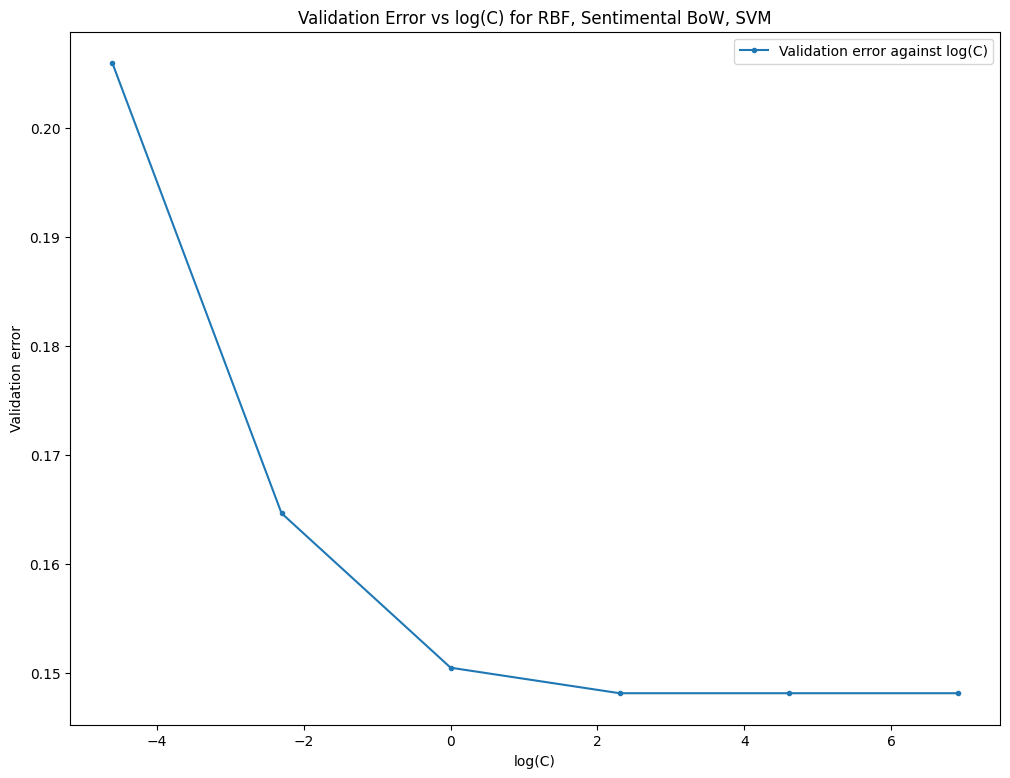

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(np.log(cs), val_err_c, label=f'Validation error against log(C)', marker='.')
plt.legend()
plt.xlabel('log(C)')
plt.ylabel('Validation error')
plt.title(f'Validation Error vs log(C) for RBF, Sentimental BoW, SVM')

In [ ]:
best_c = cs[np.argmin(val_err_c)]
best_g = gammas[np.argmin(val_err_c)]
print(f"BEST CLF: c: {best_c}, g: {best_g}")
print(f"# support vectors: {rbf_sentimental_bow_best_clf.n_support_}")
print(f"Zero-one loss on training set: {zero_one_loss(yt, rbf_sentimental_bow_best_clf.predict(Xt))}")
print(f"Zero-one loss on validation set: {zero_one_loss(yv, rbf_sentimental_bow_best_clf.predict(Xv))}")
print(f"Hinge loss on training set: {hinge_loss(yt, rbf_sentimental_bow_best_clf.decision_function(Xt))}")
print(f"Hinge loss on validation set: {hinge_loss(yv, rbf_sentimental_bow_best_clf.decision_function(Xv))}")

BEST CLF: c: 10.0, g: 1.0
# support vectors: [86 78]
Zero-one loss on training set: 0.10999999999999999
Zero-one loss on validation set: 0.1481527093596059
Hinge loss on training set: 0.2200349631064343
Hinge loss on validation set: 0.3063934205630186


### Poly with Bag of words

In [206]:
from sklearn.metrics import hinge_loss, zero_one_loss

cs = np.power(10, np.arange(-5, 2).astype(float))
gammas = np.arange(3, 10, 2)

val_err_c = np.ones(len(cs)) * np.inf
best_g_of_c = np.zeros(len(cs))
best_clf = None
all_best = np.inf
for c_idx, c in enumerate(cs):
    best_err = np.inf
    for g in gammas:
        print(f"c:{c}, degree: {g}")
        svm_clf = svm.SVC(kernel=poly_kernel_gram(BoW_inner, g), C = c)
        svm_clf.fit(Xt, yt)
        err = utils.empirical_err(svm_clf, Xv, yv)
        if err < val_err_c[c_idx]:
            val_err_c[c_idx] = err
            best_g_of_c = g
        if err < all_best:
            all_best = err
            best_clf = svm_clf

poly_bow_best_clf = best_clf

c:1e-05, degree: 3
c:1e-05, degree: 5
c:1e-05, degree: 7
c:1e-05, degree: 9
c:0.0001, degree: 3
c:0.0001, degree: 5
c:0.0001, degree: 7
c:0.0001, degree: 9
c:0.001, degree: 3
c:0.001, degree: 5
c:0.001, degree: 7
c:0.001, degree: 9
c:0.01, degree: 3
c:0.01, degree: 5
c:0.01, degree: 7
c:0.01, degree: 9
c:0.1, degree: 3
c:0.1, degree: 5
c:0.1, degree: 7
c:0.1, degree: 9
c:1.0, degree: 3
c:1.0, degree: 5
c:1.0, degree: 7
c:1.0, degree: 9
c:10.0, degree: 3
c:10.0, degree: 5
c:10.0, degree: 7
c:10.0, degree: 9


Text(0.5, 1.0, 'Validation Error vs log(C) for Poly Kernel, Sentimental BoW, SVM')

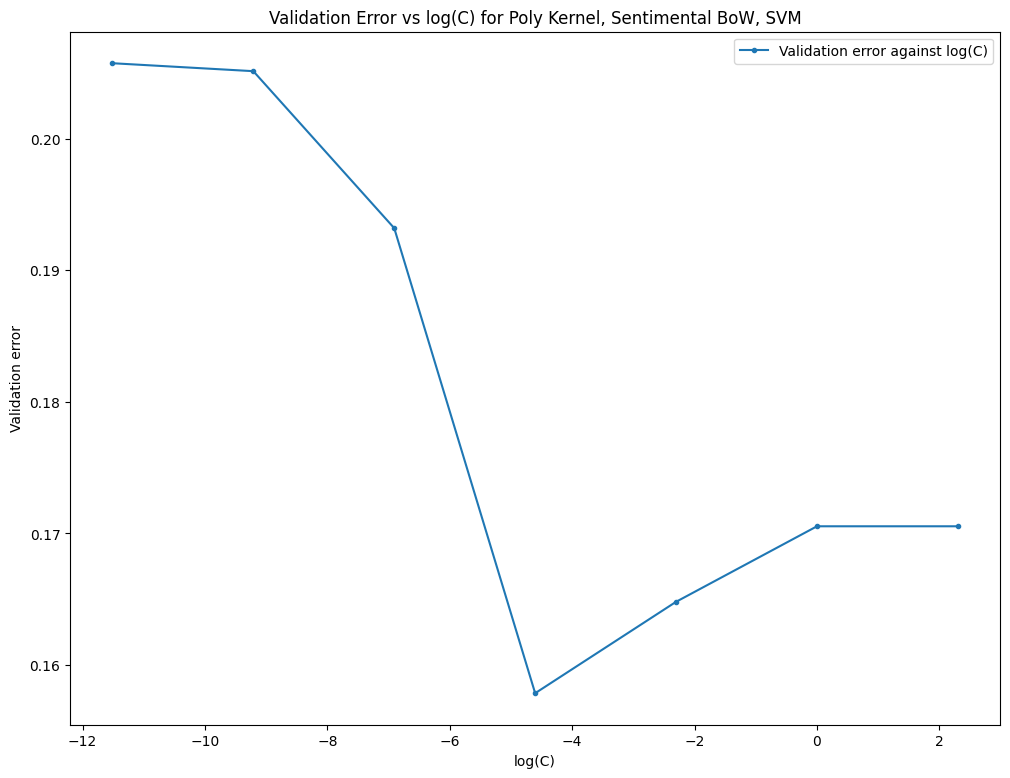

In [207]:
plt.figure(figsize=(12,9))
plt.plot(np.log(cs), val_err_c, label=f'Validation error against log(C)', marker='.')
plt.legend()
plt.xlabel('log(C)')
plt.ylabel('Validation error')
plt.title(f'Validation Error vs log(C) for Poly Kernel, Sentimental BoW, SVM')

In [208]:
best_c = cs[np.argmin(val_err_c)]
best_g = gammas[np.argmin(val_err_c)]
print(f"BEST CLF: c: {best_c}, degree: {best_g}")
print(f"# support vectors: {poly_bow_best_clf.n_support_}")
print(f"Zero-one loss on training set: {zero_one_loss(yt, poly_bow_best_clf.predict(Xt))}")
print(f"Zero-one loss on validation set: {zero_one_loss(yv, poly_bow_best_clf.predict(Xv))}")
print(f"Hinge loss on training set: {hinge_loss(yt, poly_bow_best_clf.decision_function(Xt))}")
print(f"Hinge loss on validation set: {hinge_loss(yv, poly_bow_best_clf.decision_function(Xv))}")

BEST CLF: c: 0.01, degree: 9
# support vectors: [1194  402]
Zero-one loss on training set: 0.017000000000000015
Zero-one loss on validation set: 0.15785498489425986
Hinge loss on training set: 0.040150864094825094
Hinge loss on validation set: 0.4930726049069236


### Poly with Bag of sentimental words

In [209]:
from sklearn.metrics import hinge_loss, zero_one_loss

cs = np.power(10, np.arange(-5, 2).astype(float))
gammas = np.arange(3, 10, 2)

val_err_c = np.ones(len(cs)) * np.inf
best_g_of_c = np.zeros(len(cs))
best_clf = None
all_best = np.inf
for c_idx, c in enumerate(cs):
    best_err = np.inf
    for g in gammas:
        print(f"c:{c}, d: {g}")
        svm_clf = svm.SVC(kernel=poly_kernel_gram(BoW_inner, g), C = c)
        svm_clf.fit(Xt, yt)
        err = utils.empirical_err(svm_clf, Xv, yv)
        if err < val_err_c[c_idx]:
            val_err_c[c_idx] = err
            best_g_of_c = g
        if err < all_best:
            all_best = err
            best_clf = svm_clf

poly_sentimental_bow_best_clf = best_clf

c:1e-05, d: 3
c:1e-05, d: 5
c:1e-05, d: 7
c:1e-05, d: 9
c:0.0001, d: 3
c:0.0001, d: 5
c:0.0001, d: 7
c:0.0001, d: 9
c:0.001, d: 3
c:0.001, d: 5
c:0.001, d: 7
c:0.001, d: 9
c:0.01, d: 3
c:0.01, d: 5
c:0.01, d: 7
c:0.01, d: 9
c:0.1, d: 3
c:0.1, d: 5
c:0.1, d: 7
c:0.1, d: 9
c:1.0, d: 3
c:1.0, d: 5
c:1.0, d: 7
c:1.0, d: 9
c:10.0, d: 3
c:10.0, d: 5
c:10.0, d: 7
c:10.0, d: 9


Text(0.5, 1.0, 'Validation Error vs log(C) for Poly Kernel, Sentimental BoW, SVM')

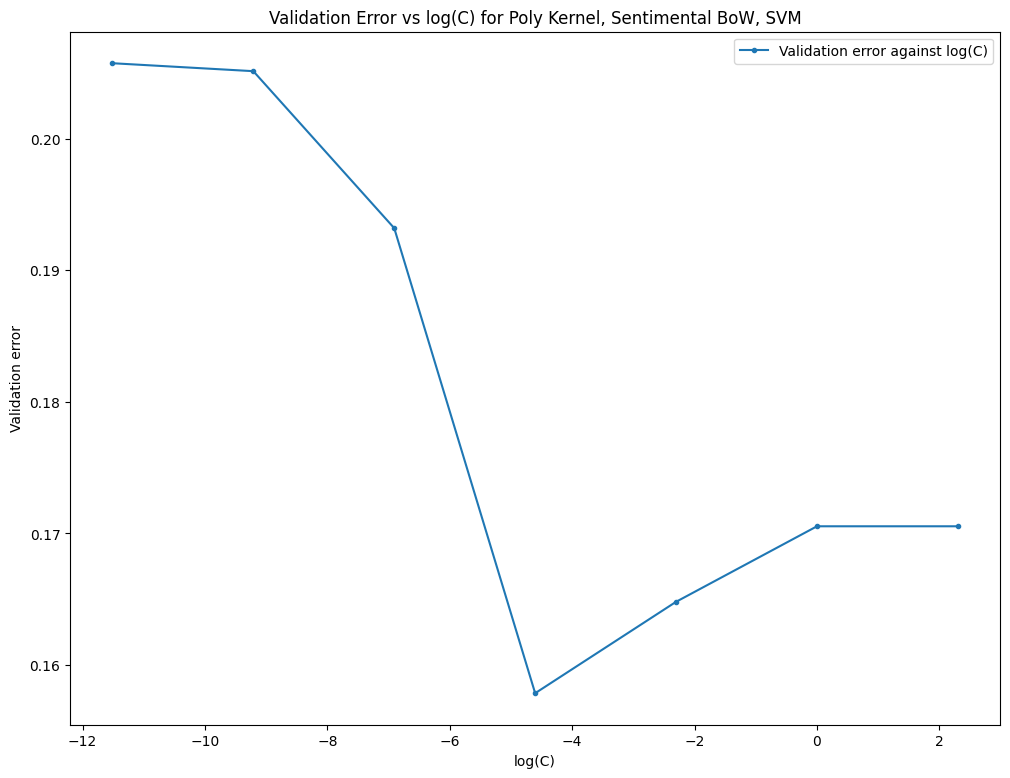

In [210]:
plt.figure(figsize=(12,9))
plt.plot(np.log(cs), val_err_c, label=f'Validation error against log(C)', marker='.')
plt.legend()
plt.xlabel('log(C)')
plt.ylabel('Validation error')
plt.title(f'Validation Error vs log(C) for Poly Kernel, Sentimental BoW, SVM')

In [215]:
best_c = cs[np.argmin(val_err_c)]
best_g = best_g_of_c[np.argmin(val_err_c)]
print(f"BEST CLF: c: {best_c}, degree: {best_g}")
print(f"# support vectors: {poly_sentimental_bow_best_clf.n_support_}")
print(f"Zero-one loss on training set: {zero_one_loss(yt, poly_sentimental_bow_best_clf.predict(Xt))}")
print(f"Zero-one loss on validation set: {zero_one_loss(yv, poly_sentimental_bow_best_clf.predict(Xv))}")
print(f"Hinge loss on training set: {hinge_loss(yt, poly_sentimental_bow_best_clf.decision_function(Xt))}")
print(f"Hinge loss on validation set: {hinge_loss(yv, poly_sentimental_bow_best_clf.decision_function(Xv))}")

IndexError: invalid index to scalar variable.

In [212]:
def my_final_predictor(x_data_to_predict_on):
    #### TASK 5 CODE
    my_predictions =  rbf_sentimental_bow_best_clf.predict(x_data_to_predict_on)   # an array of +1/-1 the same length as x_data_to_predict on
    #### TASK 5 CODE
    return my_predictions

<span style="color: red">
<h4 style="font-weight: bold">[Answer Question 3]</h4>

BEFORE LOADING THE TEST DATA, what is your estimate, based on whatever validation you would like to do using your available training data, for the generalization (ie population) error of my_final_predictor ? <br>

<h4 style="font-weight: bold">---------------------</h4>

<span style="color: blue">
Answer: my_estimated_error_rate = 0.20; given that the zero-one loss on the validation set was around 0.147, and I'd give the estimation error a somewhat significant amount (in my opinion) of 0.06
</span>

<h4 style="font-weight: bold">---------------------</h4>

You are now ready to ship your predictor!!  Hurray!!  
Let's use it, and see how well it does.

In [213]:
X_test, y_test = utils.load_data(os.path.join(os.getcwd(), "data/cleaned_tweets_test.tsv"))

In [214]:
test_predictions = my_final_predictor(X_test)
print("My test error:", np.mean(y_test != test_predictions))

My test error: 0.15453296703296704


Wow! Pretty close to the validation error, but definitely on the higher end in general.